<a href="https://colab.research.google.com/github/HKLeeeee/AI_proj_Team2/blob/main/%5BLab%5D_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from tensorflow.keras.applications import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions

In [ ]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    return img_path_list

In [ ]:
def load_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize 
    return img

In [ ]:
def create_dataset(img_dir, label, target_size, batch_size=None) :    
    img = [] # 원본이미지
    
    ## 최적화가 필요한 부분
    for i in img_dir:
        image = load_img_numpy(i, target_size)
        img.append(image)
        
    x = Dataset.from_tensor_slices(img)
    y = Dataset.from_tensor_slices(label)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [ ]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    file_name = [x.split('/')[-1][:-4] for x in img_dir]
    x_img = []

    for i in tqdm(img_dir,
                total=len(img_dir),
                position=0,
                leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

# Load Data Set

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

all_img_path, all_label = get_train_data('/content/drive/MyDrive/AI_proj/data/train')
test_img_path = get_test_data('/content/drive/MyDrive/AI_proj/data/test')

In [ ]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [ ]:
train_dataset = create_dataset(train_img_path, train_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE)
valid_dataset = create_dataset(vali_img_path, vali_label, (IMAGE_SIZE, IMAGE_SIZE), BATCH_SIZE )

In [ ]:
train_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

In [ ]:
valid_dataset

<RepeatDataset element_spec=(TensorSpec(shape=(8, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8,), dtype=tf.float32, name=None))>

# ResNet50 Model : epoch 30, learning rate 1e-4, augmentation, no dropout

## Optimizer : Adam

In [ ]:
base_model = resnet50.ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

In [ ]:
MODEL_IMAGE_SIZE = 224
input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

In [ ]:
base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 25,686,913
Trainable params: 2,099,201
Non-trainable params: 23,587,712
__________________________________

In [ ]:
LEARNING_RATE = 1e-4
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/resnet50.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 76.4793 - mae: 76.4793
Epoch 1: val_mae improved from inf to 59.11314, saving model to /content/drive/MyDrive/AI_proj/data/resnet50.ckpt
159/159 [==============================] - 14s 70ms/step - loss: 76.4793 - mae: 76.4793 - val_loss: 59.1131 - val_mae: 59.1131
Epoch 2/30
158/159 [============================>.] - ETA: 0s - loss: 74.2870 - mae: 74.2870
Epoch 2: val_mae improved from 59.11314 to 57.39779, saving model to /content/drive/MyDrive/AI_proj/data/resnet50.ckpt
159/159 [==============================] - 8s 51ms/step - loss: 73.9445 - mae: 73.9445 - val_loss: 57.3978 - val_mae: 57.3978
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 73.4783 - mae: 73.4783
Epoch 3: val_mae improved from 57.39779 to 57.02380, saving model to /content/drive/MyDrive/AI_proj/data/resnet50.ckpt
159/159 [==============================] - 9s 58ms/step - loss: 73.4783 - mae: 73.4783 - val_loss: 57.0238 - val_mae

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

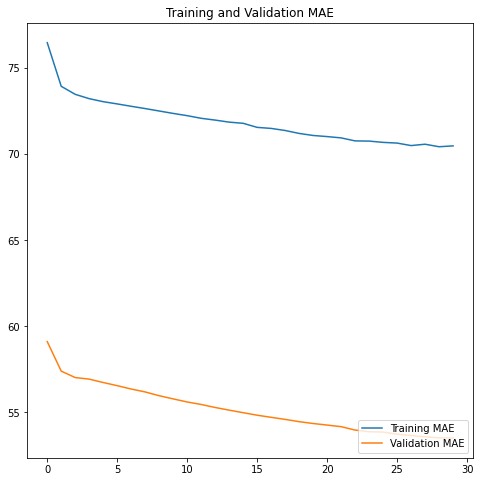

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Optimizer : SGD

In [ ]:
tf.keras.backend.clear_session()
base_model = resnet50.ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 79.5539 - mae: 79.5539
Epoch 1: val_mae improved from inf to 63.97320, saving model to /content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt
159/159 [==============================] - 11s 54ms/step - loss: 79.5539 - mae: 79.5539 - val_loss: 63.9732 - val_mae: 63.9732
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 76.6202 - mae: 76.6202
Epoch 2: val_mae improved from 63.97320 to 61.71394, saving model to /content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt
159/159 [==============================] - 7s 45ms/step - loss: 76.6202 - mae: 76.6202 - val_loss: 61.7139 - val_mae: 61.7139
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 75.3867 - mae: 75.3867
Epoch 3: val_mae improved from 61.71394 to 60.33280, saving model to /content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt
159/159 [==============================] - 7s 46ms/step - loss: 75.3867 - mae: 75.3867 - val_loss: 60.33

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

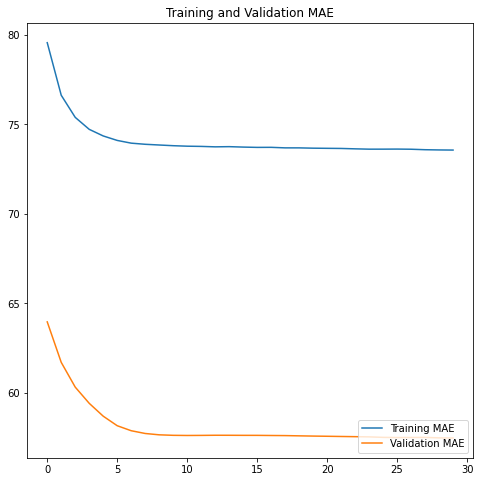

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

## Optimizer : RMS Prop

In [ ]:
tf.keras.backend.clear_session()
base_model = resnet50.ResNet50(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))


model.compile(optimizer=RMSprop(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
158/159 [============================>.] - ETA: 0s - loss: 77.0011 - mae: 77.0011
Epoch 1: val_mae improved from inf to 59.94216, saving model to /content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt
159/159 [==============================] - 13s 59ms/step - loss: 76.5824 - mae: 76.5824 - val_loss: 59.9422 - val_mae: 59.9422
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 74.1860 - mae: 74.1860
Epoch 2: val_mae improved from 59.94216 to 57.96511, saving model to /content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt
159/159 [==============================] - 7s 46ms/step - loss: 74.1860 - mae: 74.1860 - val_loss: 57.9651 - val_mae: 57.9651
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 73.5477 - mae: 73.5477
Epoch 3: val_mae improved from 57.96511 to 57.18687, saving model to /content/drive/MyDrive/AI_proj/data/resnet50_SGD.ckpt
159/159 [==============================] - 8s 48ms/step - loss: 73.5477 - mae: 73.5477 - val_loss: 57.18

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

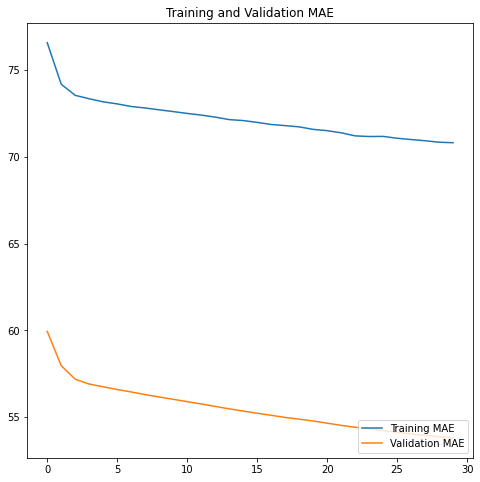

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

# MobileNetV3Small : epoch30, learning rate 1e-4, no dropout, augmentation

## Optimizer : Adam

In [ ]:
tf.keras.backend.clear_session()
MODEL_IMAGE_SIZE = 244
base_model = MobileNetV3Small(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

4349952/4334752 [==============================] - 0s 0us/step


In [ ]:
input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

In [ ]:
base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 244, 244, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 8, 8, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              590848    
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 1,530,993
Trainable params: 591,873
Non-

In [ ]:
LEARNING_RATE = 1e-4
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/moblie.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 78.1208 - mae: 78.1208
Epoch 1: val_mae improved from inf to 61.73845, saving model to /content/drive/MyDrive/AI_proj/data/moblie.ckpt
159/159 [==============================] - 7s 22ms/step - loss: 78.1208 - mae: 78.1208 - val_loss: 61.7384 - val_mae: 61.7384
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 75.3319 - mae: 75.3319
Epoch 2: val_mae improved from 61.73845 to 59.69302, saving model to /content/drive/MyDrive/AI_proj/data/moblie.ckpt
159/159 [==============================] - 2s 16ms/step - loss: 75.3319 - mae: 75.3319 - val_loss: 59.6930 - val_mae: 59.6930
Epoch 3/30
157/159 [============================>.] - ETA: 0s - loss: 75.2335 - mae: 75.2335
Epoch 3: val_mae improved from 59.69302 to 58.64133, saving model to /content/drive/MyDrive/AI_proj/data/moblie.ckpt
159/159 [==============================] - 3s 16ms/step - loss: 74.5805 - mae: 74.5805 - val_loss: 58.6413 - val_mae: 58.64

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

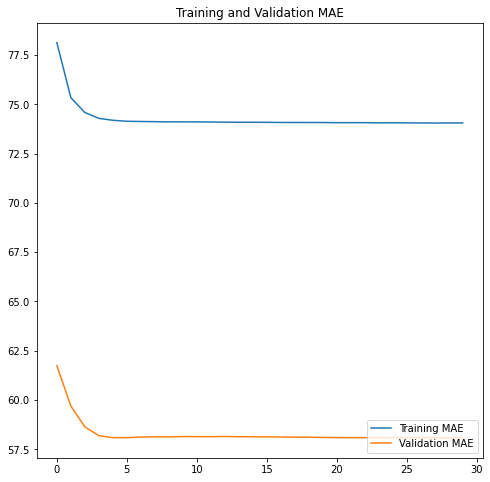

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

# Inception V2 resnet : epoch 30, 0.2 dropout, lr = 1e-4, augmentation 

## Optimizer : Adam

In [ ]:
tf.keras.backend.clear_session()
MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()



219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                       

In [ ]:
LEARNING_RATE = 1e-4
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/moblie.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 74.7022 - mae: 74.7022
Epoch 1: val_mae improved from inf to 55.82667, saving model to /content/drive/MyDrive/AI_proj/data/moblie.ckpt
159/159 [==============================] - 37s 157ms/step - loss: 74.7022 - mae: 74.7022 - val_loss: 55.8267 - val_mae: 55.8267
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 70.9807 - mae: 70.9807
Epoch 2: val_mae improved from 55.82667 to 53.07666, saving model to /content/drive/MyDrive/AI_proj/data/moblie.ckpt
159/159 [==============================] - 23s 145ms/step - loss: 70.9807 - mae: 70.9807 - val_loss: 53.0767 - val_mae: 53.0767
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 69.2038 - mae: 69.2038
Epoch 3: val_mae improved from 53.07666 to 51.16116, saving model to /content/drive/MyDrive/AI_proj/data/moblie.ckpt
159/159 [==============================] - 22s 141ms/step - loss: 69.2038 - mae: 69.2038 - val_loss: 51.1612 - val_mae:

### graph

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower left')
plt.title('Training and Validation MAE')

## Optimizer : SGD

In [ ]:
tf.keras.backend.clear_session()
MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))

LEARNING_RATE = 1e-4
model.compile(optimizer=SGD(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/inceptionresnet_sgd.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 82.2364 - mae: 82.2364
Epoch 1: val_mae improved from inf to 67.75420, saving model to /content/drive/MyDrive/AI_proj/data/inceptionresnet_sgd.ckpt
159/159 [==============================] - 35s 159ms/step - loss: 82.2364 - mae: 82.2364 - val_loss: 67.7542 - val_mae: 67.7542
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 80.2011 - mae: 80.2011
Epoch 2: val_mae improved from 67.75420 to 66.34673, saving model to /content/drive/MyDrive/AI_proj/data/inceptionresnet_sgd.ckpt
159/159 [==============================] - 22s 140ms/step - loss: 80.2011 - mae: 80.2011 - val_loss: 66.3467 - val_mae: 66.3467
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 78.9159 - mae: 78.9159
Epoch 3: val_mae improved from 66.34673 to 65.18006, saving model to /content/drive/MyDrive/AI_proj/data/inceptionresnet_sgd.ckpt
159/159 [==============================] - 22s 140ms/step - loss: 78.9159 - mae:

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

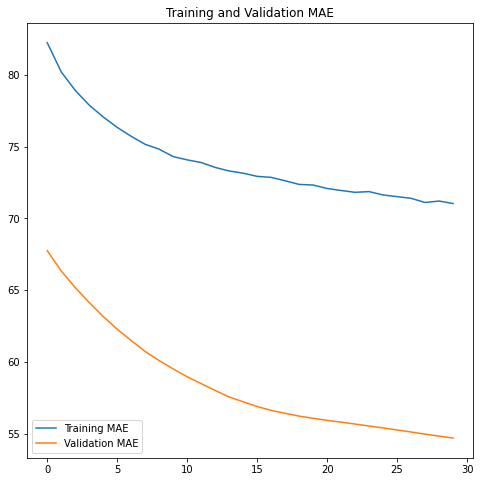

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower left')
plt.title('Training and Validation MAE')

## Optimizer : RMS prop

In [ ]:
tf.keras.backend.clear_session()
MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))

LEARNING_RATE = 1e-4
model.compile(optimizer=RMSprop(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/inceptionresnet_rms.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 74.3623 - mae: 74.3623
Epoch 1: val_mae improved from inf to 56.48937, saving model to /content/drive/MyDrive/AI_proj/data/inceptionresnet_rms.ckpt
159/159 [==============================] - 35s 158ms/step - loss: 74.3623 - mae: 74.3623 - val_loss: 56.4894 - val_mae: 56.4894
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 71.4990 - mae: 71.4990
Epoch 2: val_mae improved from 56.48937 to 53.94031, saving model to /content/drive/MyDrive/AI_proj/data/inceptionresnet_rms.ckpt
159/159 [==============================] - 23s 142ms/step - loss: 71.4990 - mae: 71.4990 - val_loss: 53.9403 - val_mae: 53.9403
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 69.8584 - mae: 69.8584
Epoch 3: val_mae improved from 53.94031 to 52.13678, saving model to /content/drive/MyDrive/AI_proj/data/inceptionresnet_rms.ckpt
159/159 [==============================] - 22s 137ms/step - loss: 69.8584 - mae:

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

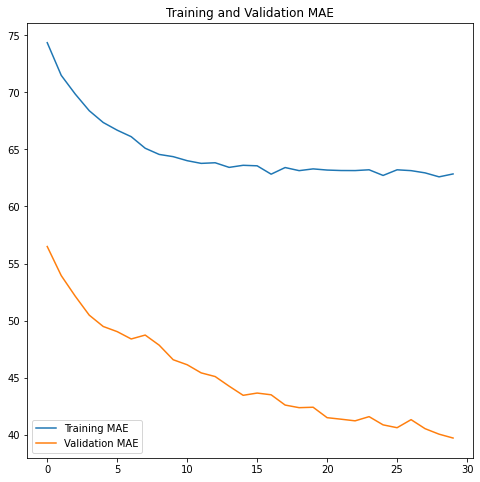

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower left')
plt.title('Training and Validation MAE')

# Inception V3  : epoch 30, 0.2 dropout, lr = 1e-4, augmentation 

## Optimizer : Adam

In [ ]:
tf.keras.backend.clear_session()
MODEL_IMAGE_SIZE = 299
base_model = inception_v3.InceptionV3(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

base_model.trainable = False
model = Sequential()
model.add(augmentation)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()



87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1)                 10

In [ ]:
LEARNING_RATE = 1e-4
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/inceptionv3.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
158/159 [============================>.] - ETA: 0s - loss: 74.8464 - mae: 74.8464
Epoch 1: val_mae improved from inf to 57.11593, saving model to /content/drive/MyDrive/AI_proj/data/inceptionv3.ckpt
159/159 [==============================] - 16s 65ms/step - loss: 74.5197 - mae: 74.5197 - val_loss: 57.1159 - val_mae: 57.1159
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 70.9056 - mae: 70.9056
Epoch 2: val_mae improved from 57.11593 to 53.61212, saving model to /content/drive/MyDrive/AI_proj/data/inceptionv3.ckpt
159/159 [==============================] - 9s 59ms/step - loss: 70.9056 - mae: 70.9056 - val_loss: 53.6121 - val_mae: 53.6121
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 68.3941 - mae: 68.3941
Epoch 3: val_mae improved from 53.61212 to 52.34906, saving model to /content/drive/MyDrive/AI_proj/data/inceptionv3.ckpt
159/159 [==============================] - 9s 58ms/step - loss: 68.3941 - mae: 68.3941 - val_loss: 52.3491 

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

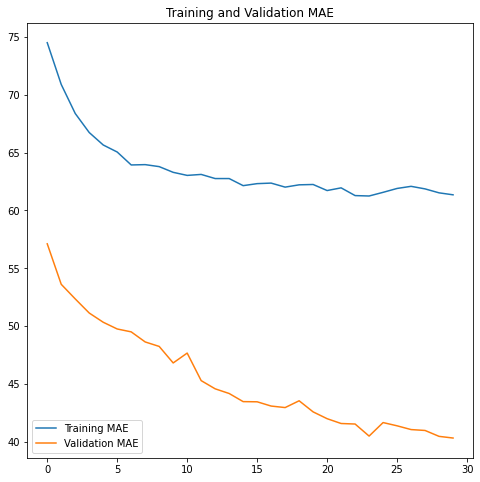

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower left')
plt.title('Training and Validation MAE')

# Inception V2 resnet Adam : Finetune

## training top layer

In [ ]:
tf.keras.backend.clear_session()

MODEL_IMAGE_SIZE = 299
base_model = inception_resnet_v2.InceptionResNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE,3)
)

input_data_s = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data_s)
x = tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')(x)
output_data_s = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
augmentation = Model(inputs=input_data_s, outputs=output_data_s)

inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(1, activation='linear')(x)
model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573

In [ ]:
base_model.trainable = False

LEARNING_RATE = 1e-4
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mae',
              metrics=['mae'])

checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_top_training.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

EPOCHS = 30
STEPS_PER_EPOCH = len(train_img_path) // BATCH_SIZE
VAL_STEPS = len(vali_img_path) // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 75.1047 - mae: 75.1047
Epoch 1: val_mae improved from inf to 56.18127, saving model to /content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_top_training.ckpt
159/159 [==============================] - 35s 158ms/step - loss: 75.1047 - mae: 75.1047 - val_loss: 56.1813 - val_mae: 56.1813
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 71.4631 - mae: 71.4631
Epoch 2: val_mae improved from 56.18127 to 53.54671, saving model to /content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_top_training.ckpt
159/159 [==============================] - 22s 141ms/step - loss: 71.4631 - mae: 71.4631 - val_loss: 53.5467 - val_mae: 53.5467
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 69.5362 - mae: 69.5362
Epoch 3: val_mae improved from 53.54671 to 51.71366, saving model to /content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_top_training.ckpt
159/159 [==============================] - 23s 

### graph

Text(0.5, 1.0, 'Training and Validation MAE')

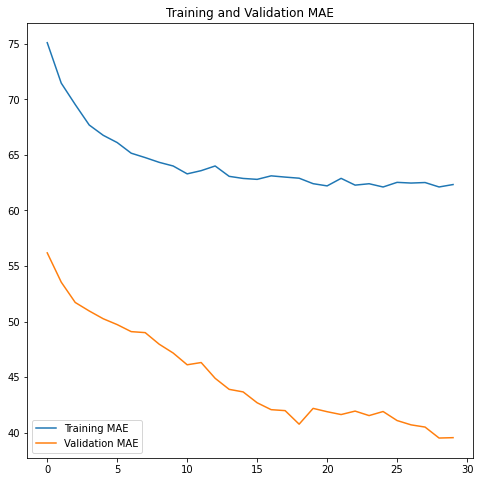

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower left')
plt.title('Training and Validation MAE')

### finetune

In [ ]:
base_model.trainable=True

fine_tune_at = int(len(base_model.layers) * 0.9)
for layer in base_model.layers[:fine_tune_at] :
    layer.trainable = False

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE/10),
              loss='mae',
              metrics=['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 299, 299, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1024)              1573

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_finetune.ckpt'
checkpointer = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_mae',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)


FINE_TUNE_EPOCHS = 30 
history_fine = model.fit(train_dataset, epochs=FINE_TUNE_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    validation_steps = VAL_STEPS,
                    callbacks=[checkpointer],
                    verbose=1)

model.save('/content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_finetune.h5')

Epoch 1/30
159/159 [==============================] - ETA: 0s - loss: 63.6441 - mae: 63.6441
Epoch 1: val_mae improved from inf to 38.00010, saving model to /content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_finetune.ckpt
159/159 [==============================] - 40s 176ms/step - loss: 63.6441 - mae: 63.6441 - val_loss: 38.0001 - val_mae: 38.0001
Epoch 2/30
159/159 [==============================] - ETA: 0s - loss: 62.2460 - mae: 62.2460
Epoch 2: val_mae improved from 38.00010 to 36.28356, saving model to /content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_finetune.ckpt
159/159 [==============================] - 26s 164ms/step - loss: 62.2460 - mae: 62.2460 - val_loss: 36.2836 - val_mae: 36.2836
Epoch 3/30
159/159 [==============================] - ETA: 0s - loss: 61.5930 - mae: 61.5930
Epoch 3: val_mae improved from 36.28356 to 35.21762, saving model to /content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_finetune.ckpt
159/159 [==============================] - 25s 156ms/step -

Text(0.5, 1.0, 'Training and Validation MAE')

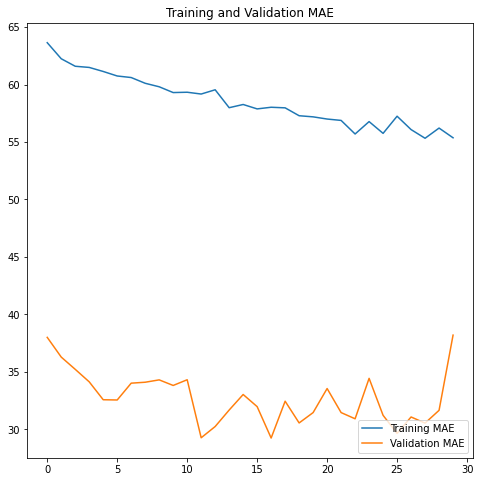

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(history_fine.history['mae'], label='Training MAE')
plt.plot(history_fine.history['val_mae'], label='Validation MAE')
plt.legend(loc='lower right')
plt.title('Training and Validation MAE')

# Prediction

test set 생성

In [ ]:
PRED_BATCH_SIZE = 10
test_dataset, file_names = create_test_dataset(test_img_path, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCH_SIZE )

  0%|          | 0/460 [00:00<?, ?it/s]

model load and predict

In [ ]:
model.load_weights('/content/drive/MyDrive/AI_proj/data/InceptionV2Resnet_finetune.ckpt')

In [ ]:
STEPS = len(test_img_path) / PRED_BATCH_SIZE
prediction = model.predict(test_dataset,
                            batch_size = PRED_BATCH_SIZE,
                            steps=STEPS)

In [ ]:
prediction.shape

(460, 1)

In [ ]:
prediction

save to csv

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/AI_proj/data/sample_submission.csv')
submission['leaf_weight'] = prediction.squeeze()
submission.to_csv('/content/drive/MyDrive/AI_proj/data/inception_v2_resnet_cnn.csv', index=False)

In [ ]:
model.save('/content/drive/MyDrive/AI_proj/Inception_V2_Resnet_finetune_nmae031.h5')

# Pixel num

In [ ]:
pixel = pd.read_csv('/content/drive/MyDrive/AI_proj/data/pixels_num.csv')
pixel.set_index('img_name', inplace=True)
pixel.drop('leaf_weight', inplace=True, axis=1)

In [ ]:
pixel

,pixels
img_name,
CASE01_01.png,19827
CASE01_02.png,23790
CASE01_03.png,28659
CASE01_04.png,33729
CASE01_05.png,38553
...,...
CASE74_25.png,81960
CASE74_26.png,82695
CASE74_27.png,83841


In [ ]:
pixel_input = Input(shape=(1,))
pixel_output = Dense(64, activation='linear')(pixel_input)
pixel_model = Model(inputs=pixel_input, outputs=pixel_output)

In [ ]:
pixel_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def create_pixel_dataset(pixel_np_array, batch_size=None) :
    
    dataset = Dataset.from_tensor_slices(pixel_list)

    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()

    return dataset

In [ ]:
pixel_dataset = create_pixel_dataset()